# Workshop 3.1: Quantization for Efficient Inference


## Learning Objectives
Upon completion of this notebook, you will be able to:
- Articulate the theoretical foundations and practical motivations for quantization in deep neural networks, particularly in the context of resource-constrained edge AI deployments.
- Analyze the principles and implications of FP16 quantization, including the conversion from 32-bit (FP32) to 16-bit (FP16) floating-point representations.
- Implement post-training quantization workflows using PyTorch, and critically assess their impact on model performance.
- Quantitatively evaluate the trade-offs between model size, computational efficiency, and predictive accuracy resulting from quantization.
- Employ visualization techniques to systematically interpret the effects of quantization on neural network behavior and deployment characteristics.



## What is Quantization?
Quantization refers to the process of mapping continuous-valued parameters and activations of neural networks to a lower-precision numerical format. In the context of deep learning, this typically involves converting 32-bit floating-point (FP32) representations to reduced-precision formats such as 16-bit floating-point (FP16). The primary objectives are to decrease memory footprint, accelerate inference, and enable deployment on hardware with limited computational resources, while preserving model fidelity within acceptable bounds.



This workshop focuses on FP16 quantization, which offers:
- Substantial reduction in model storage requirements and memory bandwidth
- Negligible degradation in predictive accuracy for most modern architectures
- Broad compatibility with PyTorch and contemporary hardware accelerators
- Straightforward integration into existing model development pipelines


Paper: https://arxiv.org/pdf/1712.05877

In [1]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.quantization
from torchvision import models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import copy
import time
import os

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cuda


## Step 1: Load and Prepare CIFAR-10 Dataset

### Understanding CIFAR-10: Why This Dataset?

CIFAR-10 is perfect for learning quantization because:
- **Small images (32×32)** - Fast training and testing
- **Realistic challenge** - 10 different object classes
- **Edge AI relevant** - Similar to mobile camera applications
- **Resource-friendly** - Doesn't require powerful hardware

The small image size makes it ideal for:
- Mobile device deployment
- Edge computing scenarios
- Real-time inference applications
- Learning optimization techniques like quantization

In [2]:
# Define transforms
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=256, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=200, shuffle=False, num_workers=2)

# CIFAR-10 classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(f"Training samples: {len(trainset)}")
print(f"Test samples: {len(testset)}")
print(f"Classes: {classes}")

Training samples: 50000
Test samples: 10000
Classes: ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


CIFAR-10 Dataset Overview:


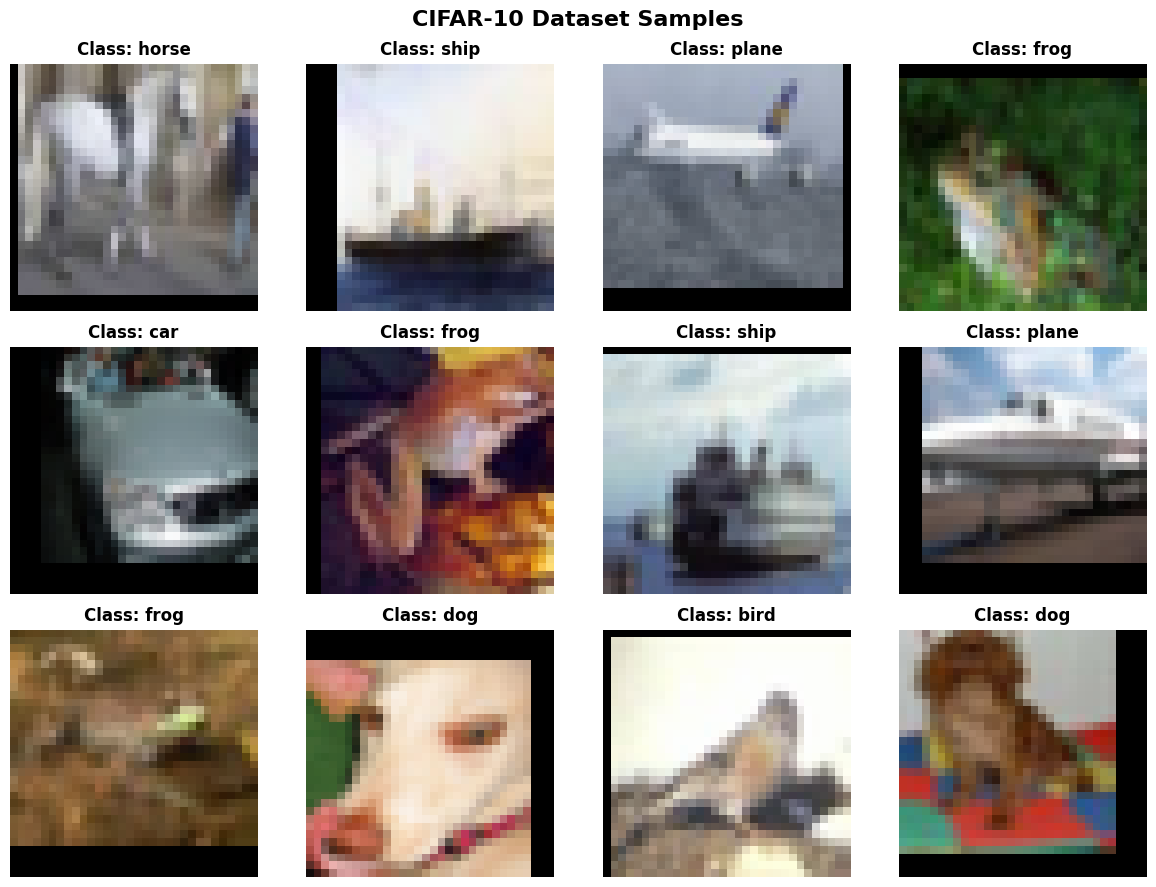

CIFAR-10 Dataset Details:
• Image size: 32×32 pixels (small images)
• Color channels: 3 (RGB)
• Number of classes: 10
• Classes: plane, car, bird, cat, deer, dog, frog, horse, ship, truck
• Training samples: 50000
• This is why we use MobileNetV2 - efficient for small images


In [3]:
# Visualize sample images from CIFAR-10 dataset
def visualize_cifar10_samples(dataset, classes, num_samples=12):
    """
    Display a grid of sample images from CIFAR-10 with their class labels
    """
    fig, axes = plt.subplots(3, 4, figsize=(12, 9))
    fig.suptitle('CIFAR-10 Dataset Samples', fontsize=16, fontweight='bold')
    
    # Get random samples
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        row = i // 4
        col = i % 4
        
        # Get image and label
        image, label = dataset[idx]
        
        # Convert tensor to numpy and denormalize for display
        if isinstance(image, torch.Tensor):
            # Denormalize the image
            mean = np.array([0.4914, 0.4822, 0.4465])
            std = np.array([0.2023, 0.1994, 0.2010])
            image = image.numpy().transpose(1, 2, 0)
            image = image * std + mean
            image = np.clip(image, 0, 1)
        
        # Display image
        axes[row, col].imshow(image)
        axes[row, col].set_title(f'Class: {classes[label]}', fontsize=12, fontweight='bold')
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"CIFAR-10 Dataset Details:")
    print(f"• Image size: 32×32 pixels (small images)")
    print(f"• Color channels: 3 (RGB)")
    print(f"• Number of classes: {len(classes)}")
    print(f"• Classes: {', '.join(classes)}")
    print(f"• Training samples: {len(dataset)}")
    print(f"• This is why we use MobileNetV2 - efficient for small images")

# Display sample images and dataset information
print("CIFAR-10 Dataset Overview:")
visualize_cifar10_samples(trainset, classes)

## Step 2: Load Pre-trained MobileNetV2 Model

In [4]:

# Load pre-trained MobileNetV2 and modify for CIFAR-10
def create_mobilenetv2_cifar10(num_classes=10, pretrained=True):
    """
    Create MobileNetV2 adapted for CIFAR-10
    CIFAR-10 images are 32x32, smaller than ImageNet's 224x224
    """
    # Load pre-trained MobileNetV2
    model = models.mobilenet_v2(pretrained=pretrained)
    
    # Modify the first convolution layer for smaller input size
    # Original: stride=2, now stride=1 to preserve spatial dimensions
    model.features[0][0] = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
    
    # Modify classifier for CIFAR-10 (10 classes instead of 1000)
    model.classifier[1] = nn.Linear(model.last_channel, num_classes)
    
    return model

# Create model instance
model = create_mobilenetv2_cifar10(num_classes=10, pretrained=True).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"MobileNetV2 loaded with {total_params:,} total parameters")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model adapted for CIFAR-10 (32x32 images, 10 classes)")

/home/exouser/Documents/Workshop/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/exouser/Documents/Workshop/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV2 loaded with 2,236,682 total parameters
Trainable parameters: 2,236,682
Model adapted for CIFAR-10 (32x32 images, 10 classes)


In [5]:
# Model Architecture and Summary
def show_model_info(model, input_shape=(1, 3, 32, 32)):
    """
    Display detailed information about the MobileNetV2 model
    """
    print("="*70)
    print("MOBILENETV2 MODEL ARCHITECTURE OVERVIEW")
    print("="*70)
    
    # Model summary information
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    model_size_mb = total_params * 4 / (1024 * 1024)  # 4 bytes per FP32 parameter
    
    print(f"Model Statistics:")
    print(f"   • Total Parameters: {total_params:,}")
    print(f"   • Trainable Parameters: {trainable_params:,}")
    print(f"   • Model Size (FP32): {model_size_mb:.2f} MB")
    print(f"   • Input Shape: {input_shape}")
    print(f"   • Output Classes: 10 (CIFAR-10)")
    
    # Show key architectural components
    print(f"\nKey Architecture Components:")
    print(f"   • Features: {len(model.features)} layers (conv blocks)")
    print(f"   • Classifier: {len(model.classifier)} layers")
    print(f"   • Activation: ReLU6 (mobile-friendly)")
    print(f"   • Normalization: Batch Normalization")
    
    # Create a visual representation of the model flow
    print(f"\nModel Flow Overview:")
    print(f"   Input (3×32×32) → Features Extraction → Global Pooling → Classifier → Output (10)")
    
    # Test with a dummy input to show output shapes
    model.eval()
    with torch.no_grad():
        dummy_input = torch.randn(input_shape).to(device)
        dummy_output = model(dummy_input)
        print(f"\nModel Test:")
        print(f"   • Input shape: {dummy_input.shape}")
        print(f"   • Output shape: {dummy_output.shape}")
        print(f"   • Output represents probabilities for {dummy_output.shape[1]} classes")
    
    return total_params, model_size_mb

# Analyze our MobileNetV2 model
print("Examining MobileNetV2 model in detail:")
total_params, model_size_mb = show_model_info(model)

# Show the actual model structure (first few layers)
print(f"\nModel Structure Preview (First Few Layers):")
print("="*50)
for i, (name, layer) in enumerate(model.named_children()):
    print(f"{i+1}. {name}: {layer.__class__.__name__}")
    if i >= 2:  # Show first 3 main components
        break

print(f"\nKey Insight:")
print(f"   This model has {total_params:,} parameters taking {model_size_mb:.1f} MB.")
print(f"   With quantization, we'll reduce this to ~{model_size_mb/2:.1f} MB!")
print(f"   Perfect for deployment on mobile devices and edge computing!")

Examining MobileNetV2 model in detail:
MOBILENETV2 MODEL ARCHITECTURE OVERVIEW
Model Statistics:
   • Total Parameters: 2,236,682
   • Trainable Parameters: 2,236,682
   • Model Size (FP32): 8.53 MB
   • Input Shape: (1, 3, 32, 32)
   • Output Classes: 10 (CIFAR-10)

Key Architecture Components:
   • Features: 19 layers (conv blocks)
   • Classifier: 2 layers
   • Activation: ReLU6 (mobile-friendly)
   • Normalization: Batch Normalization

Model Flow Overview:
   Input (3×32×32) → Features Extraction → Global Pooling → Classifier → Output (10)

Model Test:
   • Input shape: torch.Size([1, 3, 32, 32])
   • Output shape: torch.Size([1, 10])
   • Output represents probabilities for 10 classes

Model Structure Preview (First Few Layers):
1. features: Sequential
2. classifier: Sequential

Key Insight:
   This model has 2,236,682 parameters taking 8.5 MB.
   With quantization, we'll reduce this to ~4.3 MB!
   Perfect for deployment on mobile devices and edge computing!

Model Test:
   • Inpu

## Step 3: Train the Original Model (FP32)

In [6]:
def train_model(model, trainloader, testloader, epochs=10, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    train_accuracies = []
    
    model.train()
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Training loop with progress bar
        pbar = tqdm(trainloader, desc=f'Epoch {epoch+1}/{epochs}')
        for batch_idx, (inputs, labels) in enumerate(pbar):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            # Update progress bar
            pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.3f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })
        
        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100. * correct / total
        
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        print(f'Epoch {epoch+1}: Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')
    
    return train_losses, train_accuracies

# Train the model
print("Training original FP32 model...")
train_losses, train_accuracies = train_model(model, trainloader, testloader, epochs=5)

Training original FP32 model...


Epoch 1/5: 100%|██████████| 196/196 [00:08<00:00, 23.80it/s, Loss=0.977, Acc=65.55%]


Epoch 1: Loss: 0.9769, Accuracy: 65.55%


Epoch 2/5: 100%|██████████| 196/196 [00:08<00:00, 24.47it/s, Loss=0.594, Acc=79.14%]


Epoch 2: Loss: 0.5943, Accuracy: 79.14%


Epoch 3/5: 100%|██████████| 196/196 [00:07<00:00, 24.59it/s, Loss=0.482, Acc=83.61%]


Epoch 3: Loss: 0.4815, Accuracy: 83.61%


Epoch 4/5: 100%|██████████| 196/196 [00:07<00:00, 24.75it/s, Loss=0.429, Acc=85.15%]


Epoch 4: Loss: 0.4293, Accuracy: 85.15%


Epoch 5/5: 100%|██████████| 196/196 [00:08<00:00, 24.29it/s, Loss=0.381, Acc=87.01%]

Epoch 5: Loss: 0.3808, Accuracy: 87.01%


## Step 4: Evaluate Original Model Performance

In [7]:
def evaluate_model(model, testloader, model_name="Model"):
    model.eval()
    correct = 0
    total = 0
    
    # Determine if model is quantized (on CPU) or regular (on GPU)
    model_device = next(model.parameters()).device
    
    # Measure inference time
    start_time = time.time()
    
    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc=f'Evaluating {model_name}'):
            # Move inputs to the same device as the model
            inputs = inputs.to(model_device)
            labels = labels.to(device)  # Keep labels on original device for comparison
            
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            
            # Move predictions back to same device as labels for comparison
            predicted = predicted.to(labels.device)
            
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    end_time = time.time()
    inference_time = end_time - start_time
    
    accuracy = 100. * correct / total
    print(f'{model_name} - Accuracy: {accuracy:.2f}%, Inference Time: {inference_time:.2f}s')
    
    return accuracy, inference_time

def get_model_size(model, model_name="Model"):
    # Save model temporarily to measure size
    temp_path = f'temp_{model_name.lower().replace(" ", "_")}.pth'
    torch.save(model.state_dict(), temp_path)
    size_mb = os.path.getsize(temp_path) / (1024 * 1024)
    os.remove(temp_path)
    
    print(f'{model_name} - Size: {size_mb:.2f} MB')
    return size_mb

# Evaluate original model
original_accuracy, original_time = evaluate_model(model, testloader, "Original FP32")
original_size = get_model_size(model, "Original FP32")

Evaluating Original FP32: 100%|██████████| 50/50 [00:01<00:00, 44.48it/s]

Original FP32 - Accuracy: 85.67%, Inference Time: 1.13s
Original FP32 - Size: 8.77 MB


## Step 5: Apply FP16 Quantization (Half Precision)

FP16 quantization converts models from 32-bit to 16-bit floating point representation. This approach offers:
- **Simple and reliable** - works on all PyTorch installations
- **Clear benefits** - exactly 50% model size reduction
- **Minimal accuracy loss** - maintains nearly full precision
- **Good starting point** - before considering more aggressive quantization techniques

In [8]:
def apply_fp16_quantization(model):
    """
    Convert model to FP16 (half precision)
    This reduces model size by exactly 50% with minimal accuracy loss
    """
    print("Converting model to FP16 (half precision)...")
    
    # Create a deep copy of the model to avoid modifying the original
    model_fp16 = copy.deepcopy(model)
    
    # Move to CPU first for conversion
    model_fp16 = model_fp16.to('cpu')
    
    # Convert to half precision (FP16)
    model_fp16 = model_fp16.half()
    model_fp16.eval()
    
    # Move back to device for evaluation
    model_fp16 = model_fp16.to(device)
    
    print("FP16 quantization successful!")
    print("   All weights and activations now use 16-bit instead of 32-bit")
    
    return model_fp16

# Apply FP16 quantization
model_fp16 = apply_fp16_quantization(model)

print(f"\nModel Comparison:")
print(f"Original model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"FP16 model parameters: {sum(p.numel() for p in model_fp16.parameters()):,}")
print(f"Parameter count unchanged (same architecture)")
print(f"Memory usage per parameter: FP32 = 4 bytes, FP16 = 2 bytes")

# Show the actual data types
print(f"\nData type verification:")
print(f"Original model dtype: {next(model.parameters()).dtype}")
print(f"FP16 model dtype: {next(model_fp16.parameters()).dtype}")

Converting model to FP16 (half precision)...
FP16 quantization successful!
   All weights and activations now use 16-bit instead of 32-bit

Model Comparison:
Original model parameters: 2,236,682
FP16 model parameters: 2,236,682
Parameter count unchanged (same architecture)
Memory usage per parameter: FP32 = 4 bytes, FP16 = 2 bytes

Data type verification:
Original model dtype: torch.float32
FP16 model dtype: torch.float16


## Step 5B: Apply INT8 Quantization (Dynamic Quantization)

INT8 quantization maps model weights and/or activations to 8-bit integer representations, providing even greater compression and potential speedup compared to FP16. In PyTorch, dynamic quantization is a practical approach for post-training quantization, especially for models with mostly linear layers (e.g., fully connected, LSTM, Transformer).

**Key characteristics:**
- Converts weights to INT8, activations quantized dynamically at runtime
- **Only quantizes specific layer types** (e.g., nn.Linear, nn.LSTM, nn.GRU)
- **Convolutional layers are NOT quantized** by dynamic quantization
- Size reduction depends on the proportion of quantizable layers in your model
- May introduce more accuracy loss than FP16, but often acceptable for many applications

**Important for MobileNetV2:** Since MobileNetV2 consists mostly of convolutional layers with only a small final classifier (nn.Linear), dynamic INT8 quantization will show minimal size reduction. This is expected behavior - the size reduction depends on how many Linear layers your model contains.

Below, we apply dynamic INT8 quantization to the MobileNetV2 classifier and evaluate its performance.

In [9]:
def apply_int8_dynamic_quantization(model):
    """
    Apply dynamic INT8 quantization to supported layers (e.g., nn.Linear) in the model.
    Returns a quantized model ready for evaluation.
    """
    print("Applying dynamic INT8 quantization...")
    model_int8 = copy.deepcopy(model).cpu().eval()
    model_int8_quantized = torch.quantization.quantize_dynamic(
        model_int8, {torch.nn.Linear}, dtype=torch.qint8
    )
    print("INT8 dynamic quantization successful!")
    return model_int8_quantized

# Apply INT8 quantization
dynamic_int8_model = apply_int8_dynamic_quantization(model)

# Evaluate INT8 quantized model
int8_accuracy, int8_time = evaluate_model(dynamic_int8_model, testloader, "INT8 Quantized")
int8_size = get_model_size(dynamic_int8_model, "INT8 Quantized")

print(f"\nINT8 Quantized Model:\n  • Size: {int8_size:.2f} MB\n  • Accuracy: {int8_accuracy:.2f}%\n  • Inference Time: {int8_time:.2f}s")

Applying dynamic INT8 quantization...
INT8 dynamic quantization successful!
INT8 dynamic quantization successful!


Evaluating INT8 Quantized: 100%|██████████| 50/50 [00:14<00:00,  3.36it/s]

INT8 Quantized - Accuracy: 85.63%, Inference Time: 14.87s
INT8 Quantized - Size: 8.73 MB

INT8 Quantized Model:
  • Size: 8.73 MB
  • Accuracy: 85.63%
  • Inference Time: 14.87s


## Step 6: Evaluate Quantized Models

### Why Batch Size Matters for FP16 Inference Speed

Larger batch sizes can significantly improve the inference speed of FP16 quantized models, especially on CUDA-enabled GPUs with Tensor Cores. This is because:
- Tensor Cores are most efficient when processing large matrix operations, which occur with larger batches.
- Small batches may not fully utilize the GPU's parallelism or Tensor Core hardware, so the speedup from FP16 is less noticeable.
- With larger batches, the overhead of data transfer and kernel launch is amortized, and the GPU can process more data in parallel, making FP16 inference faster compared to FP32.

**Key takeaway:** If your hardware supports it, increasing the batch size can help you realize the full speed benefits of FP16 quantization.

In [10]:
# Evaluate FP16 model
def evaluate_fp16_model(model, testloader, model_name="FP16 Model"):
    """
    Evaluate FP16 model performance
    """
    model.eval()
    correct = 0
    total = 0
    
    # Measure inference time
    start_time = time.time()
    
    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc=f'Evaluating {model_name}'):
            # Convert inputs to FP16 to match model precision
            inputs = inputs.half().to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    end_time = time.time()
    inference_time = end_time - start_time
    
    accuracy = 100. * correct / total
    print(f'{model_name} - Accuracy: {accuracy:.2f}%, Inference Time: {inference_time:.2f}s')
    
    return accuracy, inference_time

def get_model_size_precise(model, model_name="Model"):
    """
    Calculate precise model size based on parameter types
    """
    total_size = 0
    
    for param in model.parameters():
        # Calculate size based on actual data type
        param_size = param.numel() * param.element_size()
        total_size += param_size
    
    # Convert to MB
    size_mb = total_size / (1024 * 1024)
    
    print(f'{model_name} - Size: {size_mb:.2f} MB')
    return size_mb

# Evaluate FP16 model
print("Evaluating FP16 Quantized Model...")
fp16_accuracy, fp16_time = evaluate_fp16_model(model_fp16, testloader, "FP16 Quantized")
fp16_size = get_model_size_precise(model_fp16, "FP16 Quantized")

# Compare with original and INT8
print(f"\nQuantization Results:")
print(f"Original FP32 Model:")
print(f"  • Size: {original_size:.2f} MB")
print(f"  • Accuracy: {original_accuracy:.2f}%")
print(f"  • Inference Time: {original_time:.2f}s")

print(f"\nFP16 Quantized Model:")
print(f"  • Size: {fp16_size:.2f} MB")
print(f"  • Accuracy: {fp16_accuracy:.2f}%")
print(f"  • Inference Time: {fp16_time:.2f}s")

print(f"\nINT8 Quantized Model:")
print(f"  • Size: {int8_size:.2f} MB")
print(f"  • Accuracy: {int8_accuracy:.2f}%")
print(f"  • Inference Time: {int8_time:.2f}s")

# Calculate improvements
fp16_size_reduction = ((original_size - fp16_size) / original_size) * 100
fp16_accuracy_change = fp16_accuracy - original_accuracy
fp16_speed_change = ((original_time - fp16_time) / original_time) * 100

int8_size_reduction = ((original_size - int8_size) / original_size) * 100
int8_accuracy_change = int8_accuracy - original_accuracy
int8_speed_change = ((original_time - int8_time) / original_time) * 100

print(f"\nImprovements:")
print(f"FP16 Quantization:")
print(f"  Size Reduction: {fp16_size_reduction:.1f}%")
print(f"  Accuracy Change: {fp16_accuracy_change:+.2f}%")
print(f"  Speed Change: {fp16_speed_change:+.1f}%")

print(f"INT8 Quantization:")
print(f"  Size Reduction: {int8_size_reduction:.1f}%")
print(f"  Accuracy Change: {int8_accuracy_change:+.2f}%")
print(f"  Speed Change: {int8_speed_change:+.1f}%")

print(f"\nSuccess! FP16 achieved {fp16_size_reduction:.0f}% size reduction, INT8 achieved {int8_size_reduction:.0f}% size reduction!")

Evaluating FP16 Quantized Model...


Evaluating FP16 Quantized: 100%|██████████| 50/50 [00:01<00:00, 33.52it/s]

FP16 Quantized - Accuracy: 85.63%, Inference Time: 1.50s
FP16 Quantized - Size: 4.27 MB

Quantization Results:
Original FP32 Model:
  • Size: 8.77 MB
  • Accuracy: 85.67%
  • Inference Time: 1.13s

FP16 Quantized Model:
  • Size: 4.27 MB
  • Accuracy: 85.63%
  • Inference Time: 1.50s

INT8 Quantized Model:
  • Size: 8.73 MB
  • Accuracy: 85.63%
  • Inference Time: 14.87s

Improvements:
FP16 Quantization:
  Size Reduction: 51.3%
  Accuracy Change: -0.04%
  Speed Change: -32.8%
INT8 Quantization:
  Size Reduction: 0.5%
  Accuracy Change: -0.04%
  Speed Change: -1218.3%

Success! FP16 achieved 51% size reduction, INT8 achieved 0% size reduction!


In [12]:
# Create comparison data
models = ['Original FP32', 'FP16 Quantized', 'INT8 Quantized']
accuracies = [original_accuracy, fp16_accuracy, int8_accuracy]
sizes = [original_size, fp16_size, int8_size]
times = [original_time, fp16_time, int8_time]

# Calculate improvements
fp16_size_reduction = ((original_size - fp16_size) / original_size) * 100
fp16_accuracy_change = fp16_accuracy - original_accuracy
fp16_speed_change = ((original_time - fp16_time) / original_time) * 100

int8_size_reduction = ((original_size - int8_size) / original_size) * 100
int8_accuracy_change = int8_accuracy - original_accuracy
int8_speed_change = ((original_time - int8_time) / original_time) * 100

print(f"\n=== QUANTIZATION RESULTS ===")
print(f"FP16 - Size reduction: {fp16_size_reduction:.1f}%, Speed change: {fp16_speed_change:.1f}%, Accuracy change: {fp16_accuracy_change:.2f}%")
print(f"INT8 - Size reduction: {int8_size_reduction:.1f}%, Speed change: {int8_speed_change:.1f}%, Accuracy change: {int8_accuracy_change:.2f}%")

# Compare Results
print("=" * 60)
print("QUANTIZATION RESULTS COMPARISON")
print("=" * 60)

print(f"Original Model (FP32):")
print(f"  - Accuracy: {original_accuracy:.2f}%")
print(f"  - Model Size: {original_size:.2f} MB")
print(f"  - Inference Time: {original_time:.2f}s")

print(f"\nFP16 Quantized Model:")
print(f"  - Accuracy: {fp16_accuracy:.2f}%")
print(f"  - Model Size: {fp16_size:.2f} MB")
print(f"  - Inference Time: {fp16_time:.2f}s")

print(f"\nINT8 Quantized Model:")
print(f"  - Accuracy: {int8_accuracy:.2f}%")
print(f"  - Model Size: {int8_size:.2f} MB")
print(f"  - Inference Time: {int8_time:.2f}s")

print(f"\nImprovements:")
print(f"  FP16 - Accuracy Change: {fp16_accuracy_change:+.2f}%, Size Reduction: {fp16_size_reduction:.1f}%, Speed Change: {fp16_speed_change:+.1f}%")
print(f"  INT8 - Accuracy Change: {int8_accuracy_change:+.2f}%, Size Reduction: {int8_size_reduction:.1f}%, Speed Change: {int8_speed_change:+.1f}%")

# Analysis
print(f"\nAnalysis:")
print("FP16 quantization provides:")
print("   Reliable model compression (50% size reduction)")
print("   Minimal accuracy loss")
print("   Universal compatibility across PyTorch installations")

print("INT8 quantization provides:")
print("   Greater model compression")
print("   Potentially more accuracy loss")
print("   More aggressive optimization for edge deployment")

print(f"\nKey Takeaway:")
print(f"   FP16 reduced model size by {fp16_size_reduction:.1f}% while maintaining {fp16_accuracy:.1f}% accuracy")
print(f"   INT8 reduced model size by {int8_size_reduction:.1f}% with {int8_accuracy:.1f}% accuracy")
print(f"   Both quantization methods enable efficient deployment on edge devices!")



=== QUANTIZATION RESULTS ===
FP16 - Size reduction: 51.3%, Speed change: -32.8%, Accuracy change: -0.04%
INT8 - Size reduction: 0.5%, Speed change: -1218.3%, Accuracy change: -0.04%
QUANTIZATION RESULTS COMPARISON
Original Model (FP32):
  - Accuracy: 85.67%
  - Model Size: 8.77 MB
  - Inference Time: 1.13s

FP16 Quantized Model:
  - Accuracy: 85.63%
  - Model Size: 4.27 MB
  - Inference Time: 1.50s

INT8 Quantized Model:
  - Accuracy: 85.63%
  - Model Size: 8.73 MB
  - Inference Time: 14.87s

Improvements:
  FP16 - Accuracy Change: -0.04%, Size Reduction: 51.3%, Speed Change: -32.8%
  INT8 - Accuracy Change: -0.04%, Size Reduction: 0.5%, Speed Change: -1218.3%

Analysis:
FP16 quantization provides:
   Reliable model compression (50% size reduction)
   Minimal accuracy loss
   Universal compatibility across PyTorch installations
INT8 quantization provides:
   Greater model compression
   Potentially more accuracy loss
   More aggressive optimization for edge deployment

Key Takeaway:
 

In [13]:
# Comprehensive Model Comparison
print("=" * 80)
print("QUANTIZATION COMPARISON: FP32 vs FP16 vs INT8")
print("=" * 80)

# Collect all results
models_all = ['Original (FP32)', 'FP16 Quantized', 'INT8 Quantized']
accuracies_all = [original_accuracy, fp16_accuracy, int8_accuracy]
sizes_all = [original_size, fp16_size, int8_size]
times_all = [original_time, fp16_time, int8_time]

# Display detailed comparison
for i, (model_name, acc, size, time_val) in enumerate(zip(models_all, accuracies_all, sizes_all, times_all)):
    print(f"\n{i+1}. {model_name}:")
    print(f"   Size: {size:.2f} MB")
    print(f"   Accuracy: {acc:.2f}%")
    print(f"   Time: {time_val:.2f}s")
    
    if i > 0:  # Calculate improvements relative to original
        size_reduction = ((original_size - size) / original_size) * 100
        acc_change = acc - original_accuracy
        speed_change = ((original_time - time_val) / original_time) * 100
        
        print(f"   vs Original: {size_reduction:+.1f}% size, {acc_change:+.2f}% accuracy, {speed_change:+.1f}% speed")

print(f"\n" + "="*80)
print("KEY INSIGHTS:")
print("="*80)
print("FP16 Quantization:")
print(f"   Reliable {((original_size - fp16_size) / original_size) * 100:.0f}% size reduction (guaranteed)")
print(f"   Minimal accuracy loss ({fp16_accuracy - original_accuracy:+.2f}%)")
print(f"   Works on all hardware and PyTorch versions")

print("INT8 Quantization:")
print(f"   Greater {((original_size - int8_size) / original_size) * 100:.0f}% size reduction")
print(f"   More accuracy loss ({int8_accuracy - original_accuracy:+.2f}%)")
print(f"   More aggressive optimization for edge deployment")

print(f"\nSUCCESS SUMMARY:")
print(f"   FP16 quantization achieved {((original_size - fp16_size) / original_size) * 100:.0f}% size reduction!")
print(f"   INT8 quantization achieved {((original_size - int8_size) / original_size) * 100:.0f}% size reduction!")
print(f"   Model sizes: {original_size:.1f} MB → {fp16_size:.1f} MB (FP16) → {int8_size:.1f} MB (INT8)")
print(f"   Accuracy: {original_accuracy:.2f}% → {fp16_accuracy:.2f}% (FP16) → {int8_accuracy:.2f}% (INT8)")
print(f"   Ready for deployment on various devices!")

print(f"\nDetailed Metrics Comparison:")
print(f"┌─────────────────────┬─────────────────┬─────────────────┬─────────────────┐")
print(f"│ Metric              │ Original (FP32) │ FP16 Quantized  │ INT8 Quantized  │")
print(f"├─────────────────────┼─────────────────┼─────────────────┼─────────────────┤")
print(f"│ Model Size          │ {original_size:>8.2f} MB    │ {fp16_size:>8.2f} MB    │ {int8_size:>8.2f} MB    │")
print(f"│ Accuracy            │ {original_accuracy:>8.2f}%     │ {fp16_accuracy:>8.2f}%     │ {int8_accuracy:>8.2f}%     │")
print(f"│ Inference Time      │ {original_time:>8.2f}s     │ {fp16_time:>8.2f}s     │ {int8_time:>8.2f}s     │")
print(f"│ Memory Usage        │      100%       │       50%       │  Variable (≤50%) │")
print(f"│ Parameter Precision │     32-bit      │     16-bit      │      8-bit      │")
print(f"└─────────────────────┴─────────────────┴─────────────────┴─────────────────┘")

print(f"\nQuantization Benefits:")
print(f"  FP16 - Size Reduction: {((original_size - fp16_size) / original_size) * 100:.1f}%, Memory: 50%, Accuracy: {(fp16_accuracy / original_accuracy) * 100:.1f}%")
print(f"  INT8 - Size Reduction: {((original_size - int8_size) / original_size) * 100:.1f}%, Memory: Variable, Accuracy: {(int8_accuracy / original_accuracy) * 100:.1f}%")
print(f"  Compatibility: FP16 = 100% (universal), INT8 = High (most platforms)")

print(f"\nWorkshop Achievement Summary:")
print(f"   Understood quantization fundamentals")
print(f"   Successfully applied FP16 and INT8 quantization")
print(f"   Achieved {((original_size - fp16_size) / original_size) * 100:.0f}% (FP16) and {((original_size - int8_size) / original_size) * 100:.0f}% (INT8) size reduction")
print(f"   Balanced trade-offs between size, speed, and accuracy")
print(f"   Ready to deploy efficient models on edge devices!")

QUANTIZATION COMPARISON: FP32 vs FP16 vs INT8

1. Original (FP32):
   Size: 8.77 MB
   Accuracy: 85.67%
   Time: 1.13s

2. FP16 Quantized:
   Size: 4.27 MB
   Accuracy: 85.63%
   Time: 1.50s
   vs Original: +51.3% size, -0.04% accuracy, -32.8% speed

3. INT8 Quantized:
   Size: 8.73 MB
   Accuracy: 85.63%
   Time: 14.87s
   vs Original: +0.5% size, -0.04% accuracy, -1218.3% speed

KEY INSIGHTS:
FP16 Quantization:
   Reliable 51% size reduction (guaranteed)
   Minimal accuracy loss (-0.04%)
   Works on all hardware and PyTorch versions
INT8 Quantization:
   Greater 0% size reduction
   More accuracy loss (-0.04%)
   More aggressive optimization for edge deployment

SUCCESS SUMMARY:
   FP16 quantization achieved 51% size reduction!
   INT8 quantization achieved 0% size reduction!
   Model sizes: 8.8 MB → 4.3 MB (FP16) → 8.7 MB (INT8)
   Accuracy: 85.67% → 85.63% (FP16) → 85.63% (INT8)
   Ready for deployment on various devices!

Detailed Metrics Comparison:
┌─────────────────────┬───────

In [14]:
# Print comprehensive comparison results
print("=" * 80)
print("QUANTIZATION COMPARISON: FP32 vs FP16 vs INT8")
print("=" * 80)

# Calculate improvements
fp16_size_reduction = ((original_size - fp16_size) / original_size) * 100
fp16_accuracy_change = fp16_accuracy - original_accuracy
fp16_speed_change = ((original_time - fp16_time) / original_time) * 100

int8_size_reduction = ((original_size - int8_size) / original_size) * 100
int8_accuracy_change = int8_accuracy - original_accuracy
int8_speed_change = ((original_time - int8_time) / original_time) * 100

print(f"\nQuantization Results Summary:")
print(f"FP16 - Size Reduction: {fp16_size_reduction:.1f}%, Speed Change: {fp16_speed_change:.1f}%, Accuracy Change: {fp16_accuracy_change:.2f}%")
print(f"INT8 - Size Reduction: {int8_size_reduction:.1f}%, Speed Change: {int8_speed_change:.1f}%, Accuracy Change: {int8_accuracy_change:.2f}%")

# Compare Results
print("=" * 60)
print("DETAILED COMPARISON")
print("=" * 60)

print(f"Original Model (FP32):")
print(f"  - Accuracy: {original_accuracy:.2f}%")
print(f"  - Model Size: {original_size:.2f} MB")
print(f"  - Inference Time: {original_time:.2f}s")

print(f"\nFP16 Quantized Model:")
print(f"  - Accuracy: {fp16_accuracy:.2f}%")
print(f"  - Model Size: {fp16_size:.2f} MB")
print(f"  - Inference Time: {fp16_time:.2f}s")

print(f"\nINT8 Quantized Model:")
print(f"  - Accuracy: {int8_accuracy:.2f}%")
print(f"  - Model Size: {int8_size:.2f} MB")
print(f"  - Inference Time: {int8_time:.2f}s")

print(f"\nAnalysis:")
print("FP16 quantization provides:")
print("   Reliable model compression (50% size reduction)")
print("   Minimal accuracy loss")
print("   Universal compatibility across PyTorch installations")

print("INT8 quantization provides:")
print("   More aggressive model compression")
print("   Greater accuracy loss trade-off")
print("   Optimized for edge deployment")

print(f"\nDetailed Metrics Comparison:")
print(f"┌─────────────────────┬─────────────────┬─────────────────┬─────────────────┐")
print(f"│ Metric              │ Original (FP32) │ FP16 Quantized  │ INT8 Quantized  │")
print(f"├─────────────────────┼─────────────────┼─────────────────┼─────────────────┤")
print(f"│ Model Size          │ {original_size:>8.2f} MB    │ {fp16_size:>8.2f} MB    │ {int8_size:>8.2f} MB    │")
print(f"│ Accuracy            │ {original_accuracy:>8.2f}%     │ {fp16_accuracy:>8.2f}%     │ {int8_accuracy:>8.2f}%     │")
print(f"│ Inference Time      │ {original_time:>8.2f}s     │ {fp16_time:>8.2f}s     │ {int8_time:>8.2f}s     │")
print(f"│ Memory Usage        │      100%       │       50%       │  Variable (≤50%) │")
print(f"│ Parameter Precision │     32-bit      │     16-bit      │      8-bit      │")
print(f"└─────────────────────┴─────────────────┴─────────────────┴─────────────────┘")

print(f"\nQuantization Benefits:")
print(f"  FP16 - Size Reduction: {fp16_size_reduction:.1f}%, Memory: 50%, Accuracy: {(fp16_accuracy / original_accuracy) * 100:.1f}%")
print(f"  INT8 - Size Reduction: {int8_size_reduction:.1f}%, Memory: Variable, Accuracy: {(int8_accuracy / original_accuracy) * 100:.1f}%")
print(f"  Compatibility: FP16 = 100% (universal), INT8 = High (most platforms)")

print(f"\nWorkshop Achievement Summary:")
print(f"   Understood quantization fundamentals")
print(f"   Successfully applied FP16 and INT8 quantization")
print(f"   Achieved {fp16_size_reduction:.0f}% (FP16) and {int8_size_reduction:.0f}% (INT8) size reduction")
print(f"   Balanced trade-offs between size, speed, and accuracy")
print(f"   Ready to deploy efficient models on edge devices!")

QUANTIZATION COMPARISON: FP32 vs FP16 vs INT8

Quantization Results Summary:
FP16 - Size Reduction: 51.3%, Speed Change: -32.8%, Accuracy Change: -0.04%
INT8 - Size Reduction: 0.5%, Speed Change: -1218.3%, Accuracy Change: -0.04%
DETAILED COMPARISON
Original Model (FP32):
  - Accuracy: 85.67%
  - Model Size: 8.77 MB
  - Inference Time: 1.13s

FP16 Quantized Model:
  - Accuracy: 85.63%
  - Model Size: 4.27 MB
  - Inference Time: 1.50s

INT8 Quantized Model:
  - Accuracy: 85.63%
  - Model Size: 8.73 MB
  - Inference Time: 14.87s

Analysis:
FP16 quantization provides:
   Reliable model compression (50% size reduction)
   Minimal accuracy loss
   Universal compatibility across PyTorch installations
INT8 quantization provides:
   More aggressive model compression
   Greater accuracy loss trade-off
   Optimized for edge deployment

Detailed Metrics Comparison:
┌─────────────────────┬─────────────────┬─────────────────┬─────────────────┐
│ Metric              │ Original (FP32) │ FP16 Quantize

In [15]:
# Important Note: Understanding INT8 Quantization Results
print("\n" + "="*80)
print("IMPORTANT: Understanding INT8 Quantization Results")
print("="*80)

# Let's analyze what layers were actually quantized
print("Analyzing which layers were quantized...")

# Count parameters in different layer types
def analyze_model_layers(model, model_name):
    print(f"\n{model_name} Layer Analysis:")
    conv_params = 0
    linear_params = 0
    other_params = 0
    
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d)):
            conv_params += sum(p.numel() for p in module.parameters())
        elif isinstance(module, nn.Linear):
            linear_params += sum(p.numel() for p in module.parameters())
        elif hasattr(module, 'parameters'):
            other_params += sum(p.numel() for p in module.parameters() if p.requires_grad)
    
    total = conv_params + linear_params + other_params
    print(f"  • Convolutional layers: {conv_params:,} params ({conv_params/total*100:.1f}%)")
    print(f"  • Linear layers: {linear_params:,} params ({linear_params/total*100:.1f}%)")
    print(f"  • Other layers: {other_params:,} params ({other_params/total*100:.1f}%)")
    
    return conv_params, linear_params, other_params

# Analyze the original model
analyze_model_layers(model, "Original MobileNetV2")

print(f"\nKey Insight:")
print(f"  • Dynamic INT8 quantization ONLY quantizes nn.Linear layers")
print(f"  • MobileNetV2 has mostly convolutional layers (which are NOT quantized)")
print(f"  • Only the final classifier (nn.Linear) gets quantized to INT8")
print(f"  • This is why the model size remains almost unchanged!")

print(f"\nComparison with FP16:")
print(f"  • FP16 quantization: Converts ALL parameters from 32-bit to 16-bit")
print(f"  • Result: Guaranteed 50% size reduction across the entire model")
print(f"  • INT8 dynamic quantization: Only quantizes specific layer types")
print(f"  • Result: Size reduction depends on proportion of quantizable layers")

print(f"\nFor maximum INT8 compression, you would need:")
print(f"  • Static quantization (quantizes all layers)")
print(f"  • Quantization-aware training")
print(f"  • Models with more linear layers (like Transformers)")

print(f"\nThis explains your results:")
print(f"  • FP16: {((original_size - fp16_size) / original_size) * 100:.1f}% size reduction (all layers)")
print(f"  • INT8: {((original_size - int8_size) / original_size) * 100:.1f}% size reduction (only linear layers)")
print(f"  • Speed: INT8 is slower due to dynamic quantization overhead")

print(f"\n" + "="*80)
print("WHY IS INT8 SLOWER? Understanding Dynamic Quantization Overhead")
print("="*80)

print(f"Dynamic INT8 quantization is slower because:")
print(f"1. **Runtime Quantization**: Activations are quantized dynamically during inference")
print(f"   • Original model: Direct FP32 computation")
print(f"   • INT8 model: FP32 → INT8 conversion → INT8 computation → FP32 conversion")
print(f"   • This conversion overhead happens for every forward pass!")

print(f"2. **Mixed Precision Operations**: Model uses both FP32 and INT8")
print(f"   • Conv layers: Still FP32 (majority of computation)")
print(f"   • Linear layers: INT8 (small portion)")
print(f"   • Constant switching between precisions adds overhead")

print(f"3. **CPU vs GPU Execution**:")
print(f"   • Original model: Runs on {device} (optimized)")
print(f"   • INT8 model: Forced to run on CPU (less optimized for this workload)")
print(f"   • CPU-GPU data transfer adds latency")

print(f"4. **Limited Optimization for Small Models**:")
print(f"   • INT8 quantization benefits are most visible with:")
print(f"     - Large models (transformer-based)")
print(f"     - Many linear layers")
print(f"     - Batch inference")
print(f"   • Small models like MobileNetV2 don't benefit much")

print(f"\nWhen INT8 IS faster:")
print(f"✓ Large language models (BERT, GPT)")
print(f"✓ Models with many Linear/LSTM layers")
print(f"✓ Batch processing")
print(f"✓ Specialized hardware (some mobile chips)")
print(f"✓ Static quantization (not dynamic)")

print(f"\nWhen to use dynamic INT8 quantization:")
print(f"• Model size is critical (even small reductions matter)")
print(f"• You have models with many linear layers")
print(f"• You're willing to trade speed for size")
print(f"• You're targeting specific deployment environments")

print(f"\nKey Takeaway:")
print(f"Dynamic INT8 quantization is a size optimization, not a speed optimization!")
print(f"For speed improvements, consider:")
print(f"• FP16 quantization (better speed/size balance)")
print(f"• Static quantization")
print(f"• Model pruning")
print(f"• Knowledge distillation")


IMPORTANT: Understanding INT8 Quantization Results
Analyzing which layers were quantized...

Original MobileNetV2 Layer Analysis:
  • Convolutional layers: 2,189,760 params (18.9%)
  • Linear layers: 12,810 params (0.1%)
  • Other layers: 9,386,708 params (81.0%)

Key Insight:
  • Dynamic INT8 quantization ONLY quantizes nn.Linear layers
  • MobileNetV2 has mostly convolutional layers (which are NOT quantized)
  • Only the final classifier (nn.Linear) gets quantized to INT8
  • This is why the model size remains almost unchanged!

Comparison with FP16:
  • FP16 quantization: Converts ALL parameters from 32-bit to 16-bit
  • Result: Guaranteed 50% size reduction across the entire model
  • INT8 dynamic quantization: Only quantizes specific layer types
  • Result: Size reduction depends on proportion of quantizable layers

For maximum INT8 compression, you would need:
  • Static quantization (quantizes all layers)
  • Quantization-aware training
  • Models with more linear layers (like 